In [121]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np

from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from itertools import compress


#### Load Recipes Data

In [122]:
recipes = json.load(open('./data/recipe_train.json'))

#### Convert recipe to text document

In [123]:
recipes_as_doc = {}

for sample in recipes:
    key = sample['cuisine']
    # If key is in the dictionary, return its value. If not, insert key with a value of default and return default.
    recipes_as_doc.setdefault(key,[]).append(' '.join(sample['ingredients']).lower())

# create a single list with all the documents
all_docs = []
for k, v in recipes_as_doc.items():
   all_docs.append(' '.join(v))

#### Tfidf vectorizer for text data

In [124]:
# code adapted from https://programminghistorian.org/en/lessons/analyzing-documents-with-tfidf

vectorizer = TfidfVectorizer(use_idf=True)
transformed_documents = vectorizer.fit_transform(all_docs)

#### Analyze results

In [125]:
transformed_documents_as_array = transformed_documents.toarray()
len(transformed_documents_as_array)
docs_scores_dfs = {}

# loop each item in transformed_documents_as_array, using enumerate to keep track of the current position
for counter, doc in enumerate(transformed_documents_as_array):
    # construct a data frame
    tf_idf_tuples = list(zip(vectorizer.get_feature_names(), doc))
    one_doc_as_df = pd.DataFrame\
        .from_records(tf_idf_tuples, columns=['term', 'score'])\
        .sort_values(by='score', ascending=False)\
        .reset_index(drop=True)
    docs_scores_dfs[list(recipes_as_doc.keys())[counter]] = one_doc_as_df

    print(list(recipes_as_doc.keys())[counter], end=' ')
    # print(one_doc_as_df)
    # output to a csv using the enumerated value for the filename
    #one_doc_as_df.to_csv("tf.idf" + counter.__str__() + ".csv")

greek southern_us filipino indian jamaican spanish italian mexican chinese british thai vietnamese cajun_creole brazilian french japanese irish korean moroccan russian 

#### Statistics of Scores

Text(0, 0.5, 'Number of Therms')

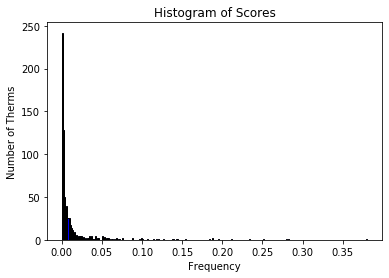

In [126]:
statistics = {}
for k in docs_scores_dfs.keys():
    df = docs_scores_dfs[k]
    scores = df['score']
    scores = scores.loc[scores>0.0]
    statistics[k] = [scores.mean(), scores.max(), scores.min(), df['score'].astype(bool).sum(axis=0)]

irish_scores = docs_scores_dfs["irish"]["score"]
irish_scores = irish_scores.loc[irish_scores>0.0]
plt.hist(irish_scores, color = 'blue', edgecolor = 'black', bins=300)
plt.title('Histogram of Scores')
plt.xlabel('Frequency')
plt.ylabel('Number of Therms')
# print(statistics)

#### Top 10 therms per cuisine

In [127]:
for k in docs_scores_dfs.keys():
    scores_df = docs_scores_dfs[k]
    print('-------------')
    print(k)
    print(scores_df.iloc[:15,:])


-------------
greek
        term     score
0      fresh  0.297130
1     pepper  0.294340
2        oil  0.287714
3       salt  0.260512
4      olive  0.260163
5       feta  0.231165
6     ground  0.226684
7      lemon  0.224591
8     garlic  0.220058
9     cheese  0.202621
10   oregano  0.162209
11     juice  0.155540
12     dried  0.152750
13  tomatoes  0.147868
14     black  0.139847
-------------
southern_us
       term     score
0      salt  0.374617
1    pepper  0.329929
2     sugar  0.285364
3    butter  0.265297
4     flour  0.227380
5    ground  0.189832
6      eggs  0.170627
7    powder  0.160286
8       oil  0.157209
9       all  0.155608
10  purpose  0.155608
11   baking  0.151546
12     milk  0.137758
13    black  0.124462
14   garlic  0.121507
-------------
filipino
       term     score
0     sauce  0.327662
1    garlic  0.325087
2    pepper  0.323156
3      salt  0.309637
4       oil  0.306418
5    onions  0.252988
6     water  0.224020
7     sugar  0.205352
8       soy  

#### Load Baskets Market Data

In [128]:
baskets = []
with open('./data/groceries.csv', newline=None) as f:
  reader = csv.reader(f)
  for row in reader:
    baskets.append([elem.replace(' ', '-') for elem in row])

#### Compute ngram for tf.idf top score 

In [129]:
top_scores_ngram = {}

for cuisine in docs_scores_dfs.keys():
    scores_df = docs_scores_dfs[cuisine]
    scores_df = scores_df[scores_df['score']>(statistics[cuisine][1]/4)]
    #scores_df = scores_df.iloc[:30,:]
    scores_df = scores_df.sort_values(by=['score'],ascending=False)
    
    ngram_scores = []
    for index, row in scores_df.iterrows():
        ngram = list(ngrams(row['term'], 3))
        score =  row['score']
        ngram_scores.append([ngram, score])
        
    top_scores_ngram[cuisine] = ngram_scores

#### Define the metric similarity

In [130]:
def jaccard_distance(a, b):
    """Calculate the jaccard distance between sets A and B"""
    a = set(a)
    b = set(b)
    return 1.0 * len(a&b)/len(a|b)

#### Compute Basket Scores
For each basket we iterate over all items and compute their similarities with the top 
terms in the cuisines docs

In [131]:
baskets_scores = []

for basket in baskets:
    similarities = {}
    for cuisine in top_scores_ngram:
        value = 0
        for item in basket:      
            item_ngram = list(ngrams(item, 3))
            for ngram_term, score in top_scores_ngram[cuisine]:
                sim = jaccard_distance(item_ngram, ngram_term)
                if sim > 0:
                    value += sim * score
                    
        similarities[cuisine] = value    
    baskets_scores.append(similarities)
           
    # print('------------------')
    # print("basket: ", basket)
    # for k in similarities:
    #     print(k, similarities[k]) 
baskets_scores_df = pd.DataFrame(baskets_scores)
baskets_scores_df=(baskets_scores_df-baskets_scores_df.mean())/baskets_scores_df.std()

#### CLustering baskets
We now try to cluster the baskets, based on the scores that they 
obtained using frequent therms of recipes

In [145]:
X = StandardScaler().fit_transform(baskets_scores_df.to_numpy())

In [147]:
# OPTICS
optics = OPTICS(min_samples=50, max_eps=0.1, xi=.05, min_cluster_size=.05)
optics.fit(X)
optics_labels = optics.labels_[optics.ordering_]
print(set(optics_labels))

{0, -1}


/home/nepotu/anaconda3/envs/dataMiningProject/lib/python3.7/site-packages/sklearn/cluster/_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [134]:
# K-Means
kMeans = KMeans(n_clusters=10, random_state=0).fit(X)
kMeans_labels = kMeans.labels_
print(set(kMeans_labels))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [151]:
# DBSCAN 
[eps, min_samples] = [0.35, 50]
dbScan = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
dbScan_labels = dbScan.labels_
print(set(dbScan_labels))
print([eps, min_samples])

{0, 1, 2, 3, 4, 5, 6, 7, 8, -1}
[0.35, 50]


#### Analysis of the method
Observe size of created basket clusters

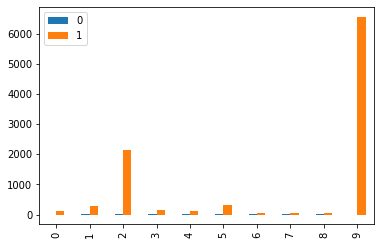

In [152]:
labels = dbScan_labels
cluster_sizes = []
for label in set(labels):
    cluster_sizes.append([label, len(baskets_scores_df[labels == label])])
pd.DataFrame(cluster_sizes).plot(kind='bar')

Select one cluster and calculate its overall score (by summing
all scores of all items of that cluster)

In [153]:
for selected_basket_cluster in set(labels):
    print("Cluster ", selected_basket_cluster)
    selected_basket_scores = baskets_scores_df[labels == selected_basket_cluster]
    aggregated_basket_cluster_score \
        = np.sum(selected_basket_scores, axis=0)\
        .sort_values(ascending=False)
    selected_baskets = list(compress(baskets, labels == selected_basket_cluster))
    selected_baskets = [' '.join(l) for l in selected_baskets]
    aggregated_basket_cluster_score = aggregated_basket_cluster_score[0:50]
    print(aggregated_basket_cluster_score)

Cluster  0
greek           25.334099
moroccan       -42.795885
cajun_creole   -54.449929
korean         -55.521350
spanish        -56.925872
chinese        -61.983712
vietnamese     -63.827349
jamaican       -64.449079
russian        -69.692967
mexican        -69.796280
italian        -69.961278
thai           -72.704772
indian         -73.094546
filipino       -73.259020
southern_us    -73.962691
british        -74.075083
japanese       -74.355694
french         -77.420671
brazilian      -77.751062
irish          -82.967259
dtype: float64
Cluster  1
brazilian       -40.902313
thai            -98.362926
southern_us    -111.703369
british        -112.232742
moroccan       -118.388615
irish          -131.460535
filipino       -133.590941
russian        -135.576932
cajun_creole   -151.175301
korean         -153.337995
spanish        -157.092377
french         -161.275276
chinese        -170.389861
vietnamese     -175.242590
jamaican       -178.025064
mexican        -191.620920
italian    

#### Baseline method - K-means
Now we will implement the baseline algorithm to compare our method with. 
A KNN method will be used. We will try to find the best K by trial and error based on the
coherence of the results because there are not many possible Ks for the given dataset.

In [139]:
baskets_as_docs = [' '.join(basket) for basket in baskets]
X = vectorizer.fit_transform(baskets_as_docs)
model = KMeans(n_clusters=10, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
baseline_labels = set(model.labels_)
for i in baseline_labels:
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Top terms per cluster:
Cluster 0:
 soda
 pastry
 sausage
 chocolate
 beverages
 waffles
 milk
 coffee
 frankfurter
 frozen
Cluster 1:
 milk
 whole
 cream
 whipped
 sour
 cheese
 butter
 ice
 yogurt
 vegetables
Cluster 2:
 juice
 vegetable
 fruit
 vegetables
 milk
 whole
 cheese
 soda
 bottled
 yogurt
Cluster 3:
 bottled
 beer
 water
 soda
 milk
 whole
 vegetables
 liquor
 wine
 canned
Cluster 4:
 vegetables
 other
 root
 frozen
 milk
 whole
 yogurt
 cheese
 pork
 bread
Cluster 5:
 specialty
 chocolate
 bar
 soda
 buns
 rolls
 milk
 cheese
 candy
 vegetables
Cluster 6:
 canned
 beer
 bags
 shopping
 yogurt
 coffee
 pastry
 beverages
 bread
 sausage
Cluster 7:
 newspapers
 milk
 whole
 bottled
 yogurt
 bread
 beer
 fruit
 soda
 pastry
Cluster 8:
 fruit
 tropical
 pip
 citrus
 vegetables
 milk
 whole
 other
 yogurt
 cheese
Cluster 9:
 buns
 rolls
 soda
 milk
 sausage
 whole
 bottled
 vegetables
 frankfurter
 cheese


#### Compute Scores of Baskets created using K-Means
For the created clusters of baskets using the baseline method, 
we calculate its scores in terms of similarity with the terms
that scored high TF-IDF for the cuisines 

In [150]:
baseline_baskets_scores = {}
for cluster in baseline_labels:
    basket_scores = baskets_scores_df[model.labels_ == cluster]
    cluster_scores = np.sum(basket_scores, axis=0).sort_values(ascending=False)
    cluster_scores = cluster_scores[0:50]
    print(cluster_scores)

irish           -31.262816
moroccan       -107.147662
cajun_creole   -135.776730
korean         -136.383174
spanish        -140.941976
chinese        -149.447140
vietnamese     -156.640266
thai           -163.718710
jamaican       -165.397759
italian        -170.140893
russian        -173.406734
mexican        -173.913034
filipino       -174.876926
southern_us    -180.464804
japanese       -184.493116
greek          -185.052200
british        -185.929912
indian         -187.851388
brazilian      -187.932765
french         -190.412965
dtype: float64
southern_us     622.775890
british         613.258282
russian         592.521232
irish           552.318653
french          547.684636
brazilian       531.078540
mexican         488.266731
italian         365.537587
thai            344.245187
filipino        279.795240
greek           239.136735
cajun_creole    214.780114
spanish         197.024062
jamaican        175.498952
moroccan        150.861814
vietnamese      124.978726
korean       